In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
if "../src/" not in sys.path:
    sys.path.insert(0,"../src/")
from pbcpy.grid import DirectGrid, ReciprocalGrid
from pbcpy.field import DirectField, ReciprocalField
from pbcpy.functionals import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
#

In [3]:
from pbcpy.local_functionals_utils import ThomasFermiEnergy, ThomasFermiPotential
from pbcpy.local_functionals_utils import vonWeizsackerEnergy, vonWeizsackerPotential

In [4]:
from pbcpy.formats.qepp import PP
from pbcpy.formats.xsf import XSF

In [5]:
from pbcpy.local_functionals_utils import x_TF_y_vW 
from pbcpy.nonlocal_functionals_utils import LindhardFunction, MGP_kernel, WT_kernel

In [6]:
from pbcpy.semilocal_xc import PBE, LDA, XC, KEDF

In [7]:
from pbcpy.local_pseudopotential import NuclearElectron

In [8]:
from pbcpy.hartree import HartreeFunctional

# Kernel analysis for SC silicon with a=2.65

### Fermi energy =7.4126 eV

In [190]:
H=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_TV/pot_H.pp').read()
H=H.field

In [191]:
XC=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_TV/pot_XC.pp').read()
XC=XC.field

In [192]:
Loc=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_TV/pot_ion.pp').read()
Loc=Loc.field

In [193]:
TV=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_TV/pot_ke.pp').read()
TV=TV.field

In [194]:
rho=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_TV/rho.pp').read()
rho=rho.field

In [195]:
WT=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_WT/pot_ke.pp').read()
WT=WT.field

In [196]:
H2eV=27.2113834279111

In [197]:
rho0=0.03185119733334818

In [198]:
KS_SC=-1.0*(H + XC + Loc) + 7.4126/H2eV

In [199]:
KS_NL=KS_SC-TV
WT_NL=WT-TV

In [200]:
q=rho.grid.get_reciprocal().gg


In [201]:
rho.integral() / rho.grid.volume

0.03185119733078106

## WT functional from pbcpy

In [202]:
def WT_tot(rho):
    q=np.sqrt(rho.grid.get_reciprocal().gg)
    rho0=rho.integral() / rho.grid.volume
    wtker = WT_kernel(q,rho0)
    rhofs = rho**(5.0/6.0)
    rhofs_g = rhofs.fft()
    rhofs_kernel = WT_kernel(q,rho0)*rhofs_g
    #WT_edens = rhofs_kernel.ifft(force_real=True)*rhofs 
    rhoos = rho**(-1.0/6.0)
    WT_pot = (5.0/6.0)*2.0* rhoos * rhofs_kernel.ifft()
    return WT_tot   

## Define the function to compure the kernel

### For WT formulation

In [203]:
KF=2.0*(3.0*np.pi**2.0*rho0)**(1.0/3.0)

In [204]:
def Ker_WT(Rho,pot):
    Rho23_g=(Rho**(2.0/3.0)).fft()
    Rho_16 = Rho**(1.0/6.0)
    Rho_56 = Rho**(5.0/6.0)
    ker1=pot*Rho_16
    ker2=Rho_56.fft()
    Ker_WT= ker1.fft()/ker2
    Ker_WT=0.6*np.real(Ker_WT)#*ker2
    return Ker_WT

In [205]:
gg=H.grid.get_reciprocal().gg
g=gg**0.5/KF

In [206]:
K_KS=Ker_WT(rho,KS_NL)
K_WT=Ker_WT(rho,WT_NL)

In [207]:
q=np.sqrt(rho.grid.get_reciprocal().gg)
rho0=rho.integral() / rho.grid.volume
wtker = WT_kernel(q,rho0)
rhofs = rho**(5.0/6.0)
rhofs_g = rhofs.fft()
rhofs_kernel = WT_kernel(q,rho0)*rhofs_g
    #WT_edens = rhofs_kernel.ifft(force_real=True)*rhofs 
rhoos = rho**(-1.0/6.0)
WT_NL_pbc = rhoos * rhofs_kernel.ifft()
WT_NL_pbc =np.real(WT_NL_pbc)

In [208]:
K_WT_pbc=Ker_WT(rho,WT_NL_pbc)

In [171]:
K_WT_pbc.shape

(24, 24, 24, 1)

In [172]:
K_WT_pbc[0,0,0,0]

5.5294743113873895e-18

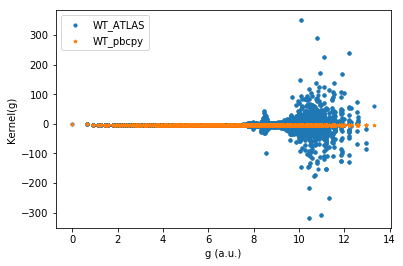

In [209]:
#p1=plt.scatter(g,K_KS,marker='v',s=10)
#plt.xlim(-0.01,4)
p2=plt.scatter(g,K_WT,s=10)
p3=plt.scatter(g,K_WT_pbc,s=10,marker='*')
#plt.ylim(-15,2)
plt.legend((p2,p3),(u'WT_ATLAS',u'WT_pbcpy'))
plt.xlabel('g (a.u.)')
plt.ylabel('Kernel(g)')
plt.savefig('Err_ker_g.eps')

/Users/wenhui/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


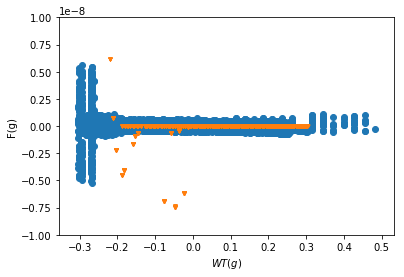

In [212]:
#plt.scatter(WT_NL_pbc,WT_NL_pbc)
#plt.scatter(WT_NL_pbc,WT_NL,marker='*',s=5)
p1=plt.scatter(WT_NL_pbc,WT_NL-WT_NL_pbc)
p2=plt.scatter(WT_NL_pbc,rho.fft(),marker='v',s=10)
plt.ylim(-0.00000001,0.00000001)
#plt.legend((p1,p2),(u '$\omega_{1}$'))
plt.xlabel(r'$WT (g) $')
plt.ylabel('F(g)')

In [175]:
rho23=(rho**(5.0/6.0)).fft()

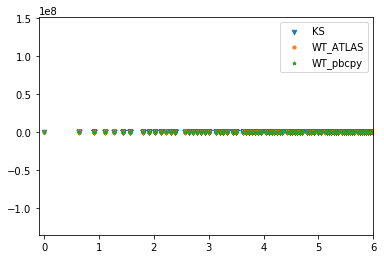

In [213]:
p1=plt.scatter(g,K_KS,marker='v',s=20)
plt.xlim(-0.1,6)
p2=plt.scatter(g,K_WT,s=10)
p3=plt.scatter(g,K_WT_pbc,s=10,marker='*')
#plt.ylim(-6,6)
plt.legend((p1,p2,p3),(u'KS',u'WT_ATLAS',u'WT_pbcpy'))
plt.savefig('Si_Effective_kernel.eps')

In [177]:
WGC =PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_WGC_k/pot_ke.pp').read()
WT =PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_WT_k/pot_ke.pp').read()
LDA= PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_LDA_k/pot_ke.pp').read()
KGAP = PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_Kgap_k/pot_ke.pp').read()
rho = PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_Kgap_k/rho.pp').read()

In [36]:
WGC=WGC.field
WT=WT.field
LDA=LDA.field
KGAP=KGAP.field
rho=rho.field

In [37]:
WGC_NL=WGC-TV
LDA_NL=LDA-TV
KGAP_NL=KGAP-TV
WT_NL=WT-TV

In [38]:
K_WGC=Ker_WT(rho,WGC_NL)
K_LDA=Ker_WT(rho,LDA_NL)
K_KGAP=Ker_WT(rho,KGAP_NL)
K_WT=Ker_WT(rho,WT_NL)
K_KS=Ker_WT(rho,KS_NL)

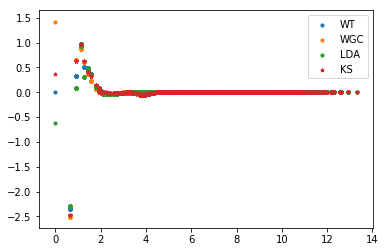

In [39]:
#plt.xlim(-0.1,6)
p1=plt.scatter(g,K_WT,s=10)
p2=plt.scatter(g,K_WGC,s=10)
p3=plt.scatter(g,K_LDA,s=10)
#p4=plt.scatter(g,K_KGAP*rho23,s=10)
p5=plt.scatter(g,K_KS,s=12,marker='*')
#plt.ylim(-15,2)
plt.legend((p1,p2,p3,p5),(u'WT',u'WGC',u'LDA',u'KS'))

#  Atom in the centern of cubic box

## Fermi enenrgy= 7.4126

In [40]:
def rho_KE(pot):
    rho_KE = pot.fft()
    gg= pot.grid.get_reciprocal().gg
    rho_KE=rho_KE*gg
    rho_KE=np.real(rho_KE)
    return rho_KE 

In [41]:
def rho_KE_r(pot,sigma=0.0):
    rho_KE = pot.fft()
    gg = pot.grid.get_reciprocal().gg
    rho_KE=rho_KE*gg*np.exp(-gg*sigma**2/4.0)
    rho_KE_r=rho_KE.ifft()
    return rho_KE_r

In [42]:
H_c=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_TF_c/pot_H.pp').read()
H_c=H_c.field

In [43]:
XC_c=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_TF_c/pot_XC.pp').read()
XC_c=XC_c.field

In [44]:
Loc_c=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_TF_c/pot_ion.pp').read()
Loc_c=Loc_c.field

In [45]:
WT_c=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_WT_c/pot_ke.pp').read()
WT_c=WT_c.field

In [46]:
WGC_c=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_WGC_c/pot_ke.pp').read()
WGC_c=WGC_c.field

In [47]:
rho_c=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_WGC_c/rho.pp').read()
rho_c=rho_c.field

In [48]:
TV_c=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_TV_c/rho.pp').read()
TV_c=TV_c.field

In [49]:
KS_c=-1.0*(H_c + XC_c + Loc_c) + 7.4126/27.211396132

In [50]:
gg=H_c.grid.get_reciprocal().gg
#KS_SC_c_g = KS_SC_c.fft()
#KS_SC_c_g = np.abs(KS_SC_c_g * gg)
g=gg**0.5

In [51]:
WGC_c_NL=WGC_c-TV_c
WT_c_NL=WT_c-TV_c
KS_c_NL=KS_c-TV_c

In [52]:
def Ker_WT(Rho,pot):
    Rho23_g=(Rho**(2.0/3.0)).fft()
    Rho_16 = Rho**(1.0/6.0)
    Rho_56 = Rho**(5.0/6.0)
    ker1=pot*Rho_16
    ker2=Rho_56.fft()
    Ker_WT= ker1.fft()#/ker2
    Ker_WT=0.6*np.real(Ker_WT)#*ker2
    return Ker_WT

In [53]:
K_WGC_c=Ker_WT(rho_c,WGC_c_NL)
K_WT_c=Ker_WT(rho_c,WT_c_NL)
K_KS_c=Ker_WT(rho_c,KS_c_NL)

In [54]:
rho56=np.real((rho_c**(5.0/6.0)).fft())

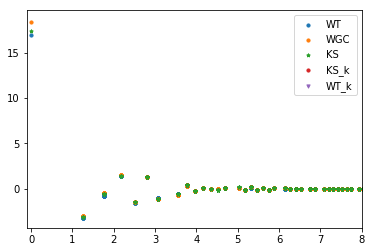

In [57]:
plt.xlim(-0.1,8)
p1=plt.scatter(g,K_WT_c,s=10)
p2=plt.scatter(g,K_WGC_c,s=10)
p3=plt.scatter(g,K_KS_c,s=12,marker='*')
#p4=plt.scatter(g,K_KS,s=10,marker='o')
#p5=plt.scatter(g,K_WT,s=10,marker='v')

#plt.ylim(-4,2)
plt.legend((p1,p2,p3,p4,p5),(u'WT',u'WGC',u'KS',u'KS_k',u'WT_k'))

In [59]:
KS_SC_c_g=rho_KE(KS_c)
KS_SC_r=rho_KE_r(KS_c)
H_g=rho_KE(H_c)
H_r=rho_KE_r(H_c)
XC_g=rho_KE(XC_c)
XC_r=rho_KE_r(XC_c)
Loc_g=rho_KE(Loc_c)
Loc_r=rho_KE_r(Loc_c)
Loc_r_numcheck = rho_KE_r(Loc_c,sigma=0)
WGC_r=rho_KE_r(WGC_c)
WGC_g=rho_KE(WGC_c)
WT_r=rho_KE_r(WT_c)
WT_g=rho_KE(WT_c)

In [60]:
Loc_r.integral()

(2.6852457466739655e-14-3.5224280474398014e-28j)

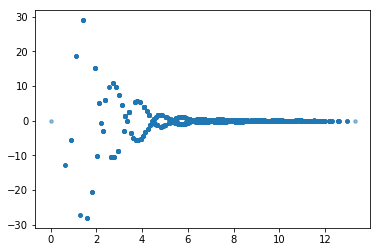

In [316]:
#p1=plt.scatter(g,KS_SC_g,marker='v',s=18.0,alpha=1.0)
p1=plt.scatter(g,KS_SC_c_g,marker='o',s=12.0,alpha=0.5)


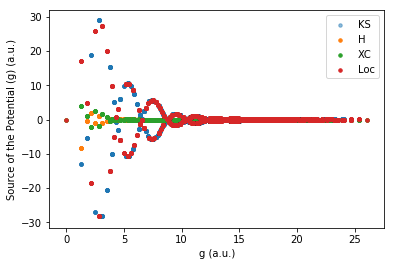

In [61]:
#p1=plt.scatter(g,KS_SC_g,marker='v',s=18.0,alpha=1.0)
p2=plt.scatter(g,KS_SC_c_g,marker='o',s=12.0,alpha=0.5)
p3=plt.scatter(g,H_g,marker='o',s=12.0,alpha=1.0)
p5=plt.scatter(g,XC_g,marker='o',s=12.0,alpha=1.0)
p6=plt.scatter(g,Loc_g,marker='o',s=12.0,alpha=1.0)
plt.legend((p2,p3,p5,p6),(u'KS',u'H',u'XC',u'Loc'))
plt.xlabel('g (a.u.)')
plt.ylabel('Source of the Potential (g) (a.u.)')
#plt.savefig()

In [62]:
nnr=24
h=np.arange(nnr,dtype='float')
xc=np.arange(nnr,dtype='float')
ion=np.arange(nnr,dtype='float')
ks=np.arange(nnr,dtype='float')
wt=np.arange(nnr,dtype='float')
wgc=np.arange(nnr,dtype='float')
for i in range(0,24):
    h[i]=H_r[i,i,i,0]
    xc[i]=XC_r[i,i,i,0]
    ion[i]=Loc_r[i,i,i,0]
    ks[i]=KS_SC_r[i,i,i,0]
    wt[i]=WT_r[i,i,i,0]
    wgc[i]=WGC_r[i,i,i,0]

/Users/wenhui/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/Users/wenhui/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
/Users/wenhui/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
/Users/wenhui/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':
/Users/wenhui/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/wenhui/anaconda/lib/python3.6/site-packages/ipykern

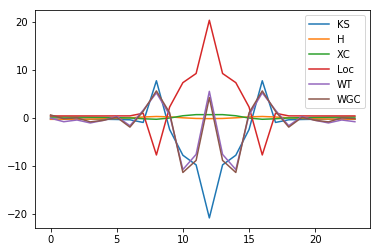

In [63]:
plt.plot(ks,label='KS')
plt.plot(h,label='H')
plt.plot(xc,label='XC')
plt.plot(ion,label='Loc')
plt.plot(wt,label='WT')
plt.plot(wgc,label='WGC')

#plt.ylim([-5,5])
plt.legend()

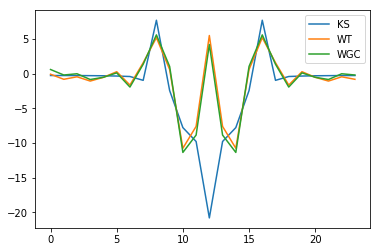

In [64]:
plt.plot(ks,label='KS')
plt.plot(wt,label='WT')
plt.plot(wgc,label='WGC')
plt.legend()

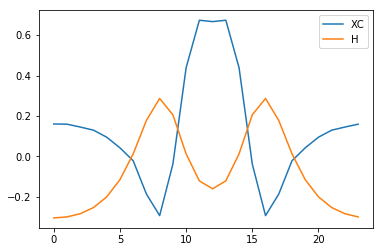

In [65]:
plt.plot(xc,label='XC')
plt.plot(h,label='H')
plt.legend()

In [66]:
rho=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Si/SC/Si_TF_c/rho.pp').read()
rho=rho.field.fft()
rho=np.abs(rho)

(0, 4)

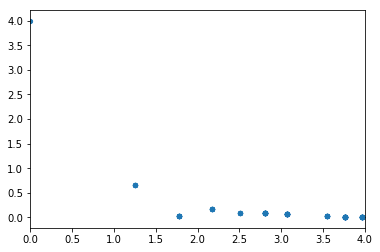

In [67]:
p1=plt.scatter(g,rho,marker='o',s=18.0,alpha=1.0)
plt.xlim([0,4])

In [72]:
-4.15630876*27.2119/2

-56.550529173122

# SC Al Fermi Energy=5.2447 eV

In [9]:
H=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Al/SC/Al_WT/pot_H.pp').read()
H=H.field

In [10]:
XC=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Al/SC/Al_WT/pot_XC.pp').read()
XC=XC.field

In [11]:
ION=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Al/SC/Al_WT/pot_ion.pp').read()
ION=ION.field

In [12]:
WT=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Al/SC/Al_WT/pot_ke.pp').read()
WT=WT.field

In [13]:
WT_s=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Al/SC/Al_WT_scf/pot_ke.pp').read()
WT_s=WT_s.field

In [14]:
rho=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Al/SC/Al_WT/rho.pp').read()
rho=rho.field

In [15]:
TV=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Al/SC/Al_TV/pot_ke.pp').read()
TV=TV.field

In [16]:
MGP=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Al/SC/Al_MGP/pot_ke.pp').read()
MGP=MGP.field

In [17]:
MGP_s=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Al/SC/Al_MGP_scf/pot_ke.pp').read()
MGP_s=MGP_s.field

In [18]:
def rho_KE(pot):
    rho_KE = pot.fft()
    gg= pot.grid.get_reciprocal().gg
    rho_KE=rho_KE*gg
    rho_KE=np.real(rho_KE)
    return rho_KE 

In [19]:
def rho_KE_r(pot,sigma=0.0):
    rho_KE = pot.fft()
    gg = pot.grid.get_reciprocal().gg
    rho_KE=rho_KE*gg*np.exp(-gg*sigma**2/4.0)
    rho_KE_r=rho_KE.ifft()
    return rho_KE_r

In [25]:
def Ker_WT(Rho,pot):
    Rho23_g=(Rho**(2.0/3.0)).fft()
    Rho_16 = Rho**(1.0/6.0)
    Rho_56 = Rho**(5.0/6.0)
    ker1=pot*Rho_16
    ker2=Rho_56.fft()
    Ker_WT= ker1.fft()#/ker2
    Ker_WT=0.6*np.real(Ker_WT)#*ker2
    return Ker_WT

In [20]:
KS=-1.0*( H + XC + ION) + 5.2447/27.211396132

In [22]:
g=KS.grid.get_reciprocal().gg
g=np.sqrt(g)

In [23]:
KS_NL=KS-TV
WT_NL=WT-TV
WT_s_NL=WT_s-TV

In [24]:
MGP_NL=MGP-TV
MGP_s_NL=MGP_s-TV

In [27]:
K_WT=Ker_WT(rho,WT_NL)
K_KS=Ker_WT(rho,KS_NL)
K_WT_s=Ker_WT(rho,WT_s_NL)
K_MGP=Ker_WT(rho,MGP_NL)
K_MGP_s=Ker_WT(rho,MGP_s_NL)

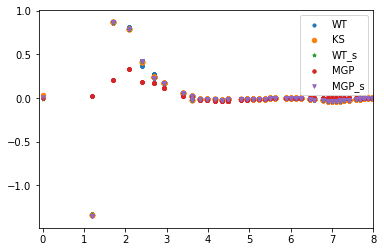

In [29]:
plt.xlim(-0.1,8)
p1=plt.scatter(g,K_WT,s=10)
p2=plt.scatter(g,K_KS,s=20)
p3=plt.scatter(g,K_WT_s,s=12,marker='*')
p4=plt.scatter(g,K_MGP,s=12)
p5=plt.scatter(g,K_MGP_s,s=12,marker='v')
plt.legend((p1,p2,p3,p4,p5),(u'WT',u'KS',u'WT_s',u'MGP',u'MGP_s'))
plt.savefig('./fig/Al_effective_kernel.eps')

In [98]:
KS_r=rho_KE_r(KS)
KS_g=rho_KE(KS)

In [99]:
WT_r=rho_KE_r(WT)
WT_g=rho_KE(WT)

In [100]:
WT_s_r=rho_KE_r(WT_s)
WT_s_g=rho_KE(WT_s)

In [81]:
H_r=rho_KE_r(H)
H_g=rho_KE(H)
XC_r=rho_KE_r(XC)
XC_g=rho_KE(XC)
ION_r=rho_KE_r(ION)
ION_g=rho_KE(ION)

In [82]:
nnr=24
h=np.arange(nnr,dtype='float')
xc=np.arange(nnr,dtype='float')
ion=np.arange(nnr,dtype='float')
ks=np.arange(nnr,dtype='float')
wt=np.arange(nnr,dtype='float')
KS_k=np.arange(nnr,dtype='float')
WT_k=np.arange(nnr,dtype='float')
WT_s_k=np.arange(nnr,dtype='float')
wt_s=np.arange(nnr,dtype='float')
rh=np.arange(nnr,dtype='float')
for i in range(0,24):
    h[i]=H_r[i,i,i,0]
    xc[i]=XC_r[i,i,i,0]
    ion[i]=ION_r[i,i,i,0]
    ks[i]=KS_r[i,i,i,0]
    wt[i]=WT_r[i,i,i,0]
    wt_s[i]=WT_s_r[i,i,i,0]
    KS_k[i]=KS[i,i,i,0]
    WT_k[i]=WT[i,i,i,0]
    WT_s_k[i]=WT_s[i,i,i,0]
    rh[i] = rho[i,i,i,0]

/Users/wenhui/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/wenhui/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  
/Users/wenhui/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/Users/wenhui/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()
/Users/wenhui/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/wenhui/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary par

## The effective electron of corresponding potential in [111] direction (Real space)

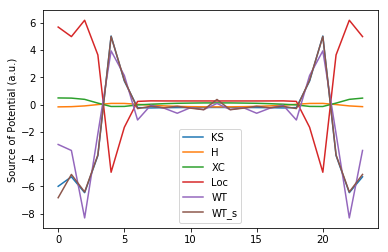

In [83]:

plt.plot(ks,label='KS')
plt.plot(h,label='H')
plt.plot(xc,label='XC')
plt.plot(ion,label='Loc')
plt.plot(wt,label='WT')
plt.plot(wt_s,label='WT_s')
#plt.plot(LDA,label='LDA')
plt.ylabel('Source of Potential (a.u.)')
#plt.ylim([-5,5])
plt.legend()
plt.savefig('fig/Al_SC_Source.eps')

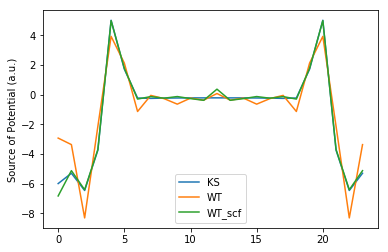

In [84]:
plt.plot(ks,label='KS')
plt.plot(wt,label='WT')
plt.plot(wt_s,label='WT_scf')
plt.legend()
plt.ylabel('Source of Potential (a.u.)')
plt.savefig('fig/Al_SC_Source_KW.eps')

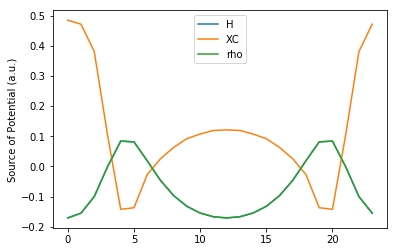

In [85]:
rho0=2.091632304623135E-002
plt.plot(h,label='H')
plt.plot(xc,label='XC')
plt.plot(4.0*np.pi*(rh-rho0),label='rho')
plt.legend()
plt.ylabel('Source of Potential (a.u.)')
plt.savefig('fig/Al_SC_Source_HXC.eps')

## Real effective kinetic potentials in real space

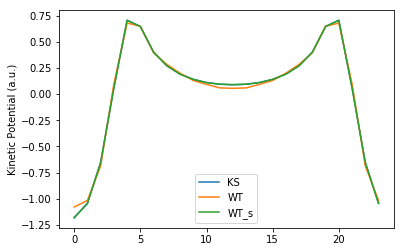

In [86]:
plt.plot(KS_k,label='KS')
plt.plot(WT_k,label='WT')
plt.plot(WT_s_k,label='WT_s')
#plt.xlim(3,22)
plt.ylabel('Kinetic Potential (a.u.)')
plt.legend()
plt.savefig('fig/Al_SC_KEDF_KWS.eps')

## The effective electron of corresponding potential in g space

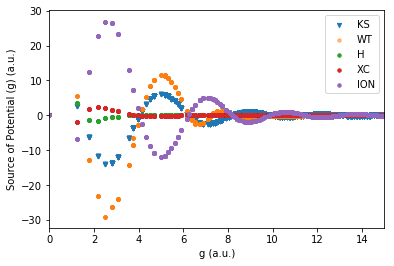

In [92]:
p1=plt.scatter(g,KS_g,marker='v',s=18.0,alpha=1.0)
p2=plt.scatter(g,WT_g,marker='o',s=12.0,alpha=0.5)
p3=plt.scatter(g,H_g,marker='o',s=12.0,alpha=1.0)
p4=plt.scatter(g,XC_g,marker='o',s=12.0,alpha=1.0)
p5=plt.scatter(g,ION_g,marker='o',s=12.0,alpha=1.0)
plt.xlim(0,15)
plt.legend((p1,p2,p3,p4,p5),(u'KS',u'WT',u'H',u'XC',u'ION'))
plt.ylabel('Source of Potential (g) (a.u.)')
plt.xlabel('g (a.u.)')
plt.savefig('fig/Al_sourcetest.eps')

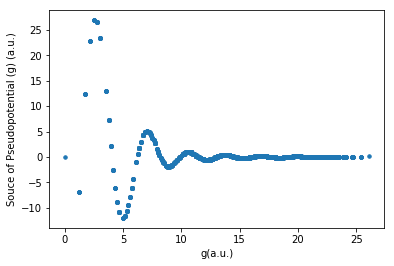

In [93]:
p1=plt.scatter(g,ION_g,marker='o',s=12.0,alpha=1.0)
plt.ylabel('Souce of Pseudopotential (g) (a.u.)' )
plt.xlabel('g(a.u.)')
plt.savefig('fig/Al_PP_g.eps')

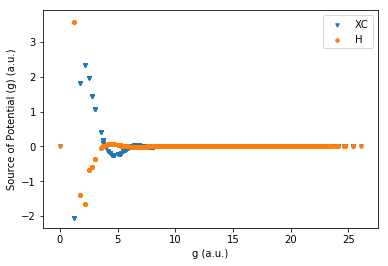

In [94]:
p1=plt.scatter(g,XC_g,marker='v',s=12.0,alpha=1.0)
p2=plt.scatter(g,H_g,marker='o',s=12.0,alpha=1.0)
plt.legend((p1,p2),(u'XC',u'H'))
plt.ylabel('Source of Potential (g) (a.u.)')
plt.xlabel('g (a.u.)')
#plt.xlim(0,8)
plt.savefig('fig/Al_HXC_g.eps')

# SC Al with a=2.2/4.0

In [95]:
ION_22=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Al/SC/Al_WT_2.2/pot_ion.pp').read()
ION_22=ION_22.field

In [96]:
ION_4=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Al/SC/Al_WT_4/pot_ion.pp').read()
ION_4=ION_4.field

In [97]:
g2=ION_22.grid.get_reciprocal().gg
g2=np.sqrt(g2)

In [98]:
g4=ION_4.grid.get_reciprocal().gg
g4=np.sqrt(g4)

In [99]:
g2.shape

(18, 18, 18, 1)

In [100]:
g4.shape

(36, 36, 36, 1)

In [101]:
def rho_KE(pot):
    rho_KE = pot.fft()
    gg= pot.grid.get_reciprocal().gg
    rho_KE=rho_KE*gg
    rho_KE=np.real(rho_KE)
    return rho_KE 

In [102]:
ION_22_r=rho_KE_r(ION_22)
ION_22_g=rho_KE(ION_22)
ION_4_r=rho_KE_r(ION_4)
ION_4_g=rho_KE(ION_4)

In [103]:
ION_22_g.shape

(18, 18, 18, 1)

In [104]:
ION_4_g.shape

(36, 36, 36, 1)

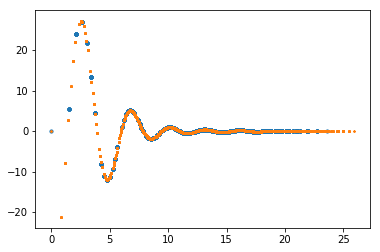

In [105]:
#p1=plt.scatter(g,ION_g,marker='v',s=12.0,alpha=1.0)
p2=plt.scatter(g2,ION_22_g,s=10)
p3=plt.scatter(g4,ION_4_g,marker='*',s=4)

## Larger Ecut

In [106]:
ION_180=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Al/SC/22_180/vloc.pp').read()
ION_180=ION_180.field/2.0

In [107]:
ION_400=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Al/SC/22_400/vloc.pp').read()
ION_400=ION_400.field/2.0

In [108]:
g180=ION_180.grid.get_reciprocal().gg
g180=np.sqrt(g180)
g180.shape

(36, 36, 36, 1)

In [109]:
g400=ION_400.grid.get_reciprocal().gg
g400=np.sqrt(g400)
g400.shape

(54, 54, 54, 1)

In [110]:
g2.shape

(18, 18, 18, 1)

In [111]:
ION_180_g=rho_KE(ION_180)
ION_400_g=rho_KE(ION_400)

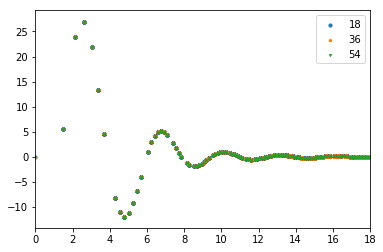

In [112]:
p1=plt.scatter(g2,ION_22_g,s=10)
#p2=plt.scatter(g4,ION_4_g,marker='*',s=4)
p2=plt.scatter(g180,ION_180_g,marker='*',s=8)
p3=plt.scatter(g400,ION_400_g,marker='v',s=4)
plt.xlim(0,18)
plt.legend((p1,p2,p3),(u'18','36','54'))

In [113]:
ION_t=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Al/SC/test/vloc.pp').read()
ION_t=ION_t.field/2.0

In [114]:
gt=ION_t.grid.get_reciprocal().gg
gt=np.sqrt(gt)
gt.shape

(45, 36, 40, 1)

In [115]:
ION_t_g=rho_KE(ION_t)

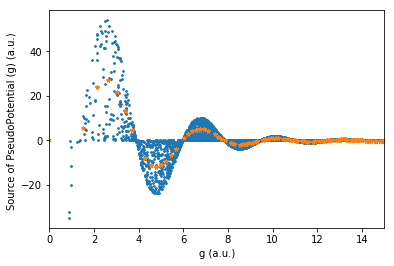

In [116]:
p1=plt.scatter(gt,ION_t_g,marker='o',s=2)
p2=plt.scatter(g2,ION_22_g,marker='*',s=10)

plt.xlim(0,15)
plt.xlabel('g (a.u.)')
plt.ylabel('Source of PseudoPotential (g) (a.u.) ')
plt.savefig('fig/Al_2PP_Source.eps')

##  PAW local peusopotential

In [117]:
ION_t=PP('/Users/wenhui/Research/Rutgers/ATLAS_MI/Benchmarks/do/Al/SC/test2/vloc.pp').read()
ION_t=ION_t.field/2.0

In [118]:
gt=ION_t.grid.get_reciprocal().gg
gt=np.sqrt(gt)
gt.shape

(36, 36, 36, 1)

In [119]:
ION_t_g=rho_KE(ION_t)

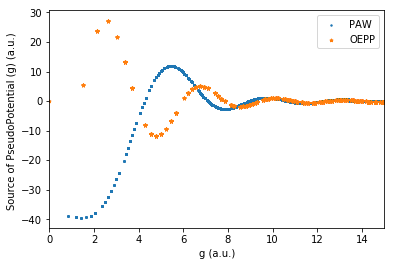

In [120]:
p1=plt.scatter(gt,ION_t_g,marker='o',s=2)
p2=plt.scatter(g2,ION_22_g,marker='*',s=10)
plt.legend((p1,p2),('PAW','OEPP'))
plt.xlim(0,15)
plt.xlabel('g (a.u.)')
plt.ylabel('Source of PseudoPotential (g) (a.u.) ')
plt.savefig('fig/Al_PAW_Source.eps')

In [107]:
2.87123400018819*5/3

4.78539000031365

In [108]:
1/4.78539000031365



0.20896938388186892

In [111]:
0.265449339552348*27.21138

7.2232428493079714